# Адаптивное семплирование Вегмана

Занятный алгоритм, который помогает оценивать(приближенно считать) количество уникальных элементов в большом множестве за фиксированное количество памяти. Конечно же он статистический и, как почти все алгоритмы приближенного счета уникальных значений, он придуман [Филиппом Флажоле](https://en.wikipedia.org/wiki/Philippe_Flajolet) (автором легендарного 

~*Боки*~)

<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSByLJ7v3a-WCJh_ingdgXX80Mtx-PadH9NDA&s" width = "500">

Ладно, я закончил несмешную шутку, Флажоле - был одним из самых крутых спецов по сборке алгоритмов приближенной оценки `count distinct problem`, когда у вас множество здоровенное и в память не лезет. Он создатель [HyperLogLog](https://habr.com/ru/companies/vk/articles/711126/)), о котором уже много классных мануалов есть, а вот про его более древнее изобретение - адаптивное семплирование - статей нет. А оно используется, например, в Clickhouse в функции `uniq`.

Вот [статья](https://algo.inria.fr/flajolet/Publications/Flajolet90.pdf), внизу реализация.

А это Филипп Флажоле:

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/7/75/PhilippeFlajolet.jpg/500px-PhilippeFlajolet.jpg" width = "400">

Адаптивное семплирование (Adaptive Sampling), описанное в статье Флажоле (Flajolet, 1990), — это вероятностный алгоритм оценки **кардинальности** (количества уникальных элементов) в потоке данных, не храня всех наблюдаемых элементов. Он эффективен по памяти и позволяет делать точные оценки даже для больших потоков, кроме того, в отличие от HyperLogLog метод дает **точную** оценку при малых кардинальностях.

###  **Основная идея**

Алгоритм использует хеш-функции, чтобы случайным образом распределить элементы потока и выбирает только те, которые удовлетворяют определённому критерию (например, начинаются с определённого количества нулей в хеш-значении). Этот критерий "адаптивно" ужесточается по мере переполнения резервуара — отсюда и название.


### **Принцип работы по шагам**

1. **Хеширование:**
   Каждый входной элемент `x` преобразуется в бинарную строку `hb` с помощью криптографической хеш-функции, в реализации ниже использована SHA-256. Это имитирует равномерное случайное распределение.

2. **Фильтрация по нулям:**
   Сохраняются только те элементы, у которых хеш начинается с `d` нулей (`starts_with_zeros(hb, d)`). Изначально `d = 0`, то есть все элементы проходят.

3. **Резервуар `B`:**
   Хранит максимум `b` уникальных элементов, прошедших фильтр. Если резервуар переполняется, алгоритм увеличивает `d` на 1 и удаляет из резервуара все элементы, не удовлетворяющие новому, более строгому фильтру (т.е. с недостаточным числом начальных нулей).

4. **Оценка количества уникальных элементов:**
   Как только поток обработан, приблизительное число уникальных элементов оценивается по формуле:

   $$
   \hat{n} = |B| \cdot 2^d
   $$

   где:

   * $|B|$ — количество элементов в резервуаре.
   * $2^d$ — компенсирует вероятность попадания в выборку (т.к. шанс, что хеш начнётся с `d` нулей — это $1/2^d$).

In [4]:
import hashlib
import random
import matplotlib.pyplot as plt
from tqdm import tqdm 

def hash_bits(x):
    # Делаем Хэш
    h = hashlib.sha256(str(x).encode()).digest()
    return ''.join(f'{byte:08b}' for byte in h)

def starts_with_zeros(bitstr, d):
    # проверяем, сколько там у нас нулей
    return bitstr[:d] == '0' * d

class AdaptiveSampling:
    def __init__(self, b):
        self.b = b            # глубина резервуара
        self.B = set()        # сам резервуар
        self.d = 0            # Кол-во "сбросов"

    def process(self, x):
        hb = hash_bits(x)
        if starts_with_zeros(hb, self.d):
            if x not in self.B:
                self.B.add(x)
            if len(self.B) > self.b:
                self.d += 1
                # Скидываем из B все, у чего нулей меньше, чем запланировали
                self.B = {k for k in self.B if starts_with_zeros(hash_bits(k), self.d)}

    def estimate(self):
        return len(self.B) * (2 ** self.d)

Минутка математики для интересующихся:

Гарантии и доверительные интервалы на получаемые оценки можно вычленить из двух статей:

1. [Оригинальная статья](https://algo.inria.fr/flajolet/Publications/Flajolet90.pdf) Флажоле
2. [Adaptive sampling revisited](https://arxiv.org/pdf/1805.08043) 2019 года, тут есть обновления оценок :)

Ну а мы просто проверим методом *~тыка~* Монте-Карло

* Берем множество кардинальности $~X$ уникальных элементов 
* Оцениваем кардинальность
* Повторяем $N$ раз для каждого значения $X$
* Усредняем
* Увеличивем $X$ и повторяем процесс

Дальше рисуем зависимость "Оценка vs Точное число"

In [5]:

def simulate_adaptive_sampling(trials=20, n_vals=range(1000, 101001, 10000), b=128):
    true_ns = []
    avg_estimates = []
    avg_errors = []

    for n in n_vals:
        estimates = []
        for _ in tqdm(range(trials)):
            sampler = AdaptiveSampling(b)
            stream = [random.randint(0, 10**9) for _ in range(n)]
            for x in stream:
                sampler.process(x)
            est = sampler.estimate()
            estimates.append(est)
        avg_est = sum(estimates) / trials
        # Здесь для симуляции я взял n, а не настоящее кол-во элементов
        # потому что множество, из которого мы берем, 10^9
        # вероятность совпадения крайне мала
        avg_err = sum(abs(est - n) / n for est in estimates) / trials

        true_ns.append(n)
        avg_estimates.append(avg_est)
        avg_errors.append(avg_err)

    return true_ns, avg_estimates, avg_errors

true_ns, ests, errs = simulate_adaptive_sampling()

100%|███████████████████████████████████████████| 20/20 [00:13<00:00,  1.50it/s]


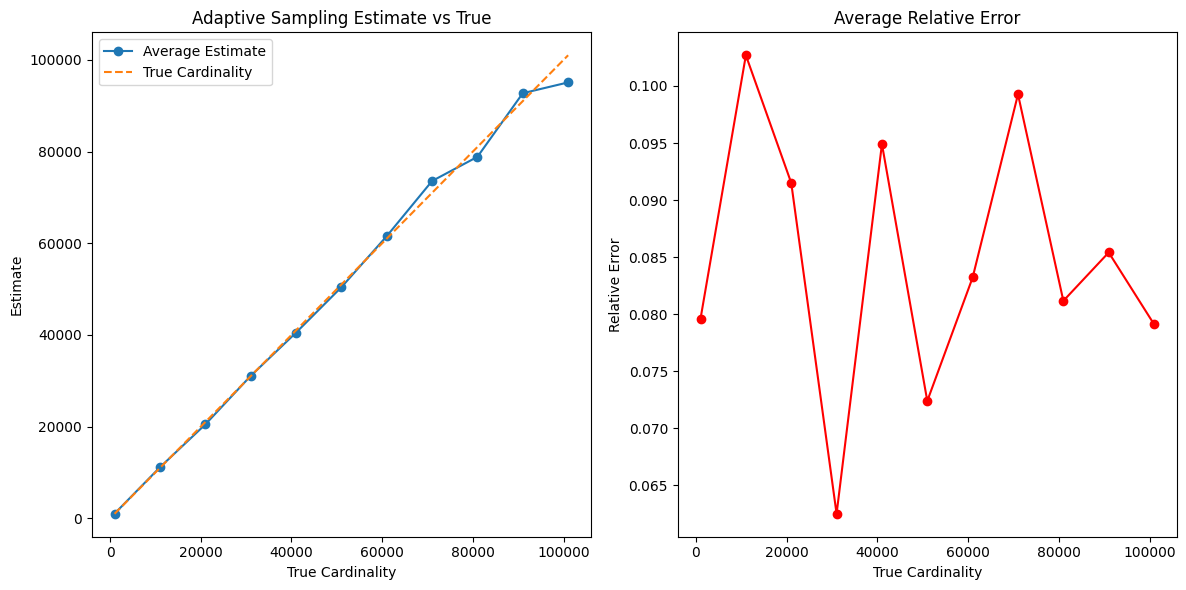

In [6]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(true_ns, ests, marker='o', label='Average Estimate')
plt.plot(true_ns, true_ns, '--', label='True Cardinality')
plt.title("Adaptive Sampling Estimate vs True")
plt.xlabel("True Cardinality")
plt.ylabel("Estimate")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(true_ns, errs, marker='o', color='red')
plt.title("Average Relative Error")
plt.xlabel("True Cardinality")
plt.ylabel("Relative Error")

plt.tight_layout()
plt.show()


# Проверка для повторяющихся значений

In [10]:
import numpy as np

sampler = AdaptiveSampling(b=128)
stream = np.random.randint(1,10**5,10**6)

print(len(np.unique(stream)))


99993


In [12]:
for x in stream:
    sampler.process(x)
est = sampler.estimate()


print(est)

# Неплохо для резервуара в 128 элементов)

90112


In [13]:
sampler = AdaptiveSampling(b=1024)
for x in stream:
    sampler.process(x)
est = sampler.estimate()


print(est)

98944


In [ ]:
# Больше резервуар - лучше точность. В Clickhouse резервуар – 65535